In [1]:
import pathlib
import numpy as np
import skimage
import plotly.graph_objects as go

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib.path import Path as pltpath
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.cm as mcm


import open3d as o3d
from copy import deepcopy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from pin_segment import RgbdPinFetcher, SfMPinFetcher

In [3]:
dataset_root = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin')
pin_ref_folder = pathlib.Path(r'/home/crest/Documents/Github/PotatoScan/3dscan/03_sfm_rgbd_registration/pin_ref')

In [4]:
rgbd_fetcher = RgbdPinFetcher(dataset_root)
sfm_fetcher = SfMPinFetcher(dataset_root, pin_ref_folder)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [5]:
potato_id = 'R3-3'

rgbd_data = rgbd_fetcher.get(potato_id, show=True)
sfm_data = sfm_fetcher.get(potato_id, visualize=True)

Thresh=0.35 get pin convex hull volumn 96018.77215018909 > 60, denoise first
Thresh=0.3 get pin convex hull volumn 92337.85037083643 > 60, denoise first
Thresh=0.25 get pin convex hull volumn 66611.87525249115 > 60, denoise first
Thresh=0.2 get pin convex hull volumn 3900.371686427296 > 60, denoise first
Stop at thresh=0.2 with hull volume = 57.303338228588636 after denoising


In [6]:
from pin_center import find_pin_center

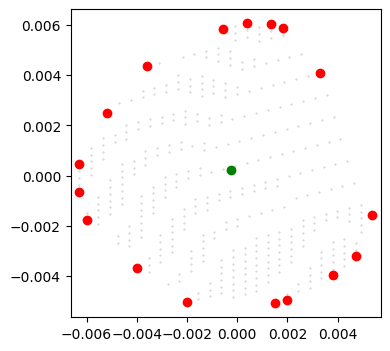

In [7]:
sfm_pin_data = find_pin_center(sfm_data['pin_pcd'], circle_color=[0,0,0], show=True)
rgbd_pin_data = find_pin_center(rgbd_data['pin_pcd'], circle_color=[0,0,0],visualize=True)

Visualize for preprocessing rsults (frame 1)

In [8]:
sfm_data.keys()

dict_keys(['pin_idx', 'pcd', 'pcd_offset_colormap', 'pin_pcd_strengthen', 'pin_pcd'])

In [9]:
rgbd_data.keys()

dict_keys(['pcd', 'pin_pcd', 'pin_idx'])

In [10]:
rgbd_pin_data.keys()

dict_keys(['circle_center_3d', 'circle_radius', 'vector', 'projected_cloud', 'circle_mesh', 'vector_lineset'])

In [11]:
o3d.visualization.draw_geometries([
    #sfm & rgbd raw data
    sfm_data['pcd'], rgbd_data['pcd'],
    # pin segmetation result (with color strength)
    sfm_data['pin_pcd_strengthen'], rgbd_data['pin_pcd'],
    # sfm hsv intermediate visualization
    sfm_data['pcd_offset_colormap'],
    # regressed circle
    sfm_pin_data['circle_mesh'], rgbd_pin_data['circle_mesh'],
    # circle plane normal
    sfm_pin_data['vector_lineset'], rgbd_pin_data['vector_lineset'], 
])

ICP Alignemnt

In [12]:
from icp_align import correct_vector_direction

In [13]:
sfm_pin_vector = correct_vector_direction(
    np.asarray(sfm_data['pcd'].points), sfm_pin_data['vector'], sfm_pin_data['circle_center_3d']
)

rgbd_pin_vector = correct_vector_direction(
    np.asarray(rgbd_data['pcd'].points), rgbd_pin_data['vector'], rgbd_pin_data['circle_center_3d']
)

In [14]:
sfm_pin_data['vector'], sfm_pin_vector

(array([ 0.07642455, -0.99317705,  0.08808312]),
 array([ 0.07642455, -0.99317705,  0.08808312]))

In [15]:
rgbd_pin_data['vector'], rgbd_pin_vector

(array([-0.83435823,  0.15978767, -0.52755497]),
 array([-0.83435823,  0.15978767, -0.52755497]))

In [17]:
from scipy.spatial.transform import Rotation

In [20]:
def create_rotational_transform_matrix(P1, N1, P2, N2, rotation_point=None):
    # 将输入向量标准化
    N1 = N1 / np.linalg.norm(N1)
    N2 = N2 / np.linalg.norm(N2)
    
    # 计算旋转轴和旋转角度
    cross_product = np.cross(N1, N2)
    dot_product = np.dot(N1, N2)

    if rotation_point is None:
        rotation_point = P1
    
    # 当两个向量平行时，叉积为零
    if np.allclose(cross_product, 0):
        # 如果点积为-1，向量相反，需要绕垂直于这些向量的轴旋转180度
        if np.isclose(dot_product, -1):
            # 选择一个与N1垂直的轴作为旋转轴
            perp_vector = np.array([1, 0, 0]) if abs(N1[0]) < abs(N1[1]) else np.array([0, 1, 0])
            rotation_axis = np.cross(N1, perp_vector)
            rotation_angle = np.pi
        else:
            # 向量重合，无需旋转
            rotation_axis = [1, 0, 0]  # 默认轴
            rotation_angle = 0
    else:
        rotation_axis = cross_product
        rotation_angle = np.arccos(dot_product)
    
    # 使用scipy来构建旋转矩阵
    rotation_matrix = Rotation.from_rotvec(rotation_axis * rotation_angle).as_matrix()
    
    # 创建平移矩阵以将旋转点移至原点
    translation_to_origin = np.eye(4)
    translation_to_origin[:3, 3] = -rotation_point
    
    # 创建平移矩阵以将旋转点移回其原始位置
    translation_back = np.eye(4)
    translation_back[:3, 3] = rotation_point
    
    # 创建旋转矩阵的4x4版本
    rot_matrix_4x4 = np.eye(4)
    rot_matrix_4x4[:3, :3] = rotation_matrix
    
    # 组合变换：平移到原点，旋转，然后平移回去
    combined_transform = translation_back @ rot_matrix_4x4 @ translation_to_origin
    
    # 计算从P1到P2的平移向量，并将其添加到变换矩阵中
    translation_vector = P2 - P1
    combined_transform[:3, 3] += translation_vector
    
    return combined_transform

In [49]:
transform_matrix =  create_rotational_transform_matrix(
    rgbd_pin_data['circle_center_3d'], rgbd_pin_vector,
    sfm_pin_data['circle_center_3d'], sfm_pin_vector,
)
transform_matrix

array([[ 0.13416383, -0.85197435, -0.50610254,  0.14925414],
       [ 0.8081049 , -0.20153607,  0.55348865, -0.29119861],
       [-0.57355605, -0.4832421 ,  0.66144579, -0.04039971],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [50]:
rgbd_pcd_pin_t = deepcopy(rgbd_data['pcd']).transform(transform_matrix)
o3d.visualization.draw_geometries([sfm_data['pcd'], rgbd_data['pcd'], rgbd_pcd_pin_t], window_name="source")

In [71]:
def draw_registration_result(source, target, transformation, paint_color=True, offset=[0,0,0], show=False):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    if paint_color:
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)

    # add offsets
    if offset != [0,0,0]:
        xyz = np.asarray(source_temp.points) + np.array(offset)
        source_temp.points = o3d.utility.Vector3dVector(xyz)

        xyz = np.asarray(target_temp.points) + np.array(offset)
        target_temp.points = o3d.utility.Vector3dVector(xyz)

    if show:
        o3d.visualization.draw_geometries([source_temp, target_temp])
    else:
        return source_temp, target_temp

In [25]:
def paint_pcd_binary(pcd, pin_idx):
    potato_temp = pcd.select_by_index(pin_idx, invert=True)
    pin_temp = pcd.select_by_index(pin_idx, invert=False)

    potato_temp.paint_uniform_color(np.array([0,0,1]))
    pin_temp.paint_uniform_color(np.array([1,0,0]))

    return potato_temp + pin_temp

In [66]:
def color_based_icp(
        source_binary_pcd, target_binary_pcd, initial_matrix, 
        voxel_size=0.001, geometry_weight=0.3, threshold=0.002
    ):
    """_summary_

    Parameters
    ----------
    source_binary_pcd : o3d.PointCloud
        rgbd point cloud
    target_binary_pcd : o3d.PointCloud
        sfm point cloud
    voxel_size : float, optional
        the size for voxel downsampling, by default 0.001
    color_weight : float, optional
        the weight of color vs geometry, from 0 to 1, by default 0.7
    threshold: float, optional
        the distance? threshold to stop ICP align iterations, by default 0.002 (2mm)


    Note
    ----
    By passing initial_matrix to `registration_colored_icp` gives a different (worse) results 
    than transforming first and then icp, and finally multiple two matrix together
    """
    source_binary_pcd_t = deepcopy(source_binary_pcd).transform(initial_matrix)

    source_pcd_down = source_binary_pcd_t.voxel_down_sample(voxel_size)
    target_pcd_down = target_binary_pcd.voxel_down_sample(voxel_size)

    source_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    target_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    
    result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_pcd_down, target_pcd_down, threshold, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationForColoredICP(lambda_geometric=geometry_weight), # weight of color, smaller means color more important
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000),
    )
    
    return result_icp.transformation @ initial_matrix


In [68]:
sfm_pcd_bin = paint_pcd_binary(sfm_data['pcd'], sfm_data['pin_idx'])
rgbd_pcd_bin = paint_pcd_binary(rgbd_data['pcd'], rgbd_data['pin_idx'])

/tmp/ipykernel_886508/2073701616.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  potato_temp = pcd.select_by_index(pin_idx, invert=True)
/tmp/ipykernel_886508/2073701616.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pin_temp = pcd.select_by_index(pin_idx, invert=False)


In [27]:
o3d.visualization.draw_geometries([rgbd_pcd_bin, sfm_pcd_bin])

In [40]:
matrix = color_based_icp(rgbd_pcd_bin, sfm_pcd_bin, transform_matrix)
matrix

array([[-0.5448387 , -0.69193893,  0.47367849, -0.08895622],
       [ 0.62928666,  0.03595177,  0.77634127, -0.34207253],
       [-0.55421032,  0.72106032,  0.41584003,  0.0372225 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [41]:
draw_registration_result(rgbd_data['pcd'], sfm_data['pcd'], matrix, paint_color=False)

looks strange

In [69]:
matrix = color_based_icp(rgbd_pcd_bin, sfm_pcd_bin, transform_matrix)
matrix

array([[-0.60096558, -0.66923251,  0.43699911, -0.06875865],
       [ 0.60404681, -0.02223592,  0.79663857, -0.34584665],
       [-0.52341935,  0.74272028,  0.41761079,  0.03254208],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [70]:
draw_registration_result(rgbd_data['pcd'], sfm_data['pcd'], matrix, paint_color=False)

visualize frame 2

In [81]:
rgbd_temp, sfm_temp = draw_registration_result(rgbd_data['pcd'], sfm_data['pcd'], matrix, paint_color=False, offset=[0.1,0,0])
# rgbd_bin_temp, sfm_bin_temp = draw_registration_result(rgbd_pcd_bin, sfm_pcd_bin, matrix, paint_color=False, offset=[0.1,0.1,0])

o3d.visualization.draw_geometries([
    # initial alignment
    sfm_data['pcd'], copy.deepcopy(rgbd_data['pcd']).transform(transform_matrix),
    # after alignment
    rgbd_temp, sfm_temp, 
    # rgbd_bin_temp, sfm_bin_temp, 
])